In [1]:
from collections import Counter

from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
import string

import re

import pandas as pd
import numpy as np

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, ENGLISH_STOP_WORDS

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedShuffleSplit, GridSearchCV

from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier

from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc, precision_recall_curve
from sklearn.pipeline import Pipeline

import matplotlib.pyplot as plt
plt.style.use('ggplot')

import emoji

from imblearn.over_sampling import SMOTE

from src.Preprocessing import *
from src.EDA import *
from src.Modelling import *

In [2]:
# autoreload python file to take in changes 
%load_ext autoreload
%autoreload 2

In [3]:
df = pd.read_csv('data/tweets.csv')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19599 entries, 0 to 19598
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  19599 non-null  int64 
 1   tweetID     19599 non-null  int64 
 2   edInput     19599 non-null  int64 
 3   text        19599 non-null  object
dtypes: int64(3), object(1)
memory usage: 612.6+ KB


In [5]:
df.drop(columns=['Unnamed: 0'], inplace=True)

In [6]:
df.head()

,tweetID,edInput,text
0,1257097624555061250,1,The new-market graveyard is full of firms that...
1,1257102148497801221,1,"Avocados are in, pork bellies out in the era o..."
2,1257104676920721420,1,U.S. officials believe China covered up the ex...
3,1257106675355582465,1,The intelligence community briefed Trump twice...
4,1257106786978594817,1,REGISTER: As co-founder of remote software com...


There appears to be no null values in this dataset.

In [7]:
# check shape of dataframe
df.shape

(19599, 3)

In [8]:
# pd.set_option modifies the maximum column width, allowing more data
# to be displayed
pd.set_option('display.max_colwidth', 100)

In [9]:
df.head()

,tweetID,edInput,text
0,1257097624555061250,1,The new-market graveyard is full of firms that got trapped in their original models. The most su...
1,1257102148497801221,1,"Avocados are in, pork bellies out in the era of pandemic eating https://t.co/VcbnMZK7Qt"
2,1257104676920721420,1,U.S. officials believe China covered up the extent of the coronavirus outbreak—and how contagiou...
3,1257106675355582465,1,The intelligence community briefed Trump twice in the eight days before he imposed travel restri...
4,1257106786978594817,1,"REGISTER: As co-founder of remote software company @basecamp, @jasonfried has been preaching the..."


Check for any potential class imbalance.

In [10]:
df['edInput'].value_counts()

1    19175
0      424
Name: edInput, dtype: int64

In [11]:
print('{:.1%} of tweets were correctly classified according to the editors'.format(19175/(19175+424)))
print('{:.1%} of tweets were not correctly classified according to the editors'.format(424/(19175+424)))

97.8% of tweets were correctly classified according to the editors
2.2% of tweets were not correctly classified according to the editors


It appears that there is a significant class imbalance, which must be accounted for when creating the classification model.

It is common to see emojis in Tweets, perhaps these emojis should be included when constructing the model. It would be helpful to see what kinds of emojis are in the dataset and if it is worth including them.

Create a new column to separate emojis from the tweets.

In [12]:
df['emojis'] = [extract_emojis(tweet) for tweet in df['text']]

After visualizing the top 10 emojis, it appears that emojis only make up around 1.3% of the dataset, which is a negligible amount and will probably not bear much meaning for the model. 

These can be removed from the tweets.

In [13]:
df['emojis'].value_counts()[:10]

     19338
⚡       46
➡       36
⬇       30
👇       27
🚀        5
▶        4
📉        3
🎧        3
📈        3
Name: emojis, dtype: int64

After some preliminary EDA, the tweets will be cleaned of http links, emojis, punctuations, and numbers that are not embedded in words. 

Created a comparison between stemmed and lemmatized words to decide which method would be better to use for this analysis.

In [14]:
# Compare stem and lemmatized words reviews
stemmer = PorterStemmer()
tokenized_words = word_tokenize(df['text'][2])
stemmed_words = [stemmer.stem(word) for word in tokenized_words]

lemm = WordNetLemmatizer()
lemm_words = [lemm.lemmatize(word) for word in tokenized_words]

print('Stemmed Words:')
print(stemmed_words, '\n')
print('Lemmatized Words')
print(lemm_words)

Stemmed Words:
['u.s.', 'offici', 'believ', 'china', 'cover', 'up', 'the', 'extent', 'of', 'the', 'coronaviru', 'outbreak—and', 'how', 'contagi', 'the', 'diseas', 'is—to', 'stock', 'up', 'on', 'medic', 'suppli', 'need', 'to', 'respond', 'to', 'it', ',', 'intellig', 'document', 'show', ',', '@', 'AP', 'report', 'http', ':', '//t.co/0qqiokwr10'] 

Lemmatized Words
['U.S.', 'official', 'believe', 'China', 'covered', 'up', 'the', 'extent', 'of', 'the', 'coronavirus', 'outbreak—and', 'how', 'contagious', 'the', 'disease', 'is—to', 'stock', 'up', 'on', 'medical', 'supply', 'needed', 'to', 'respond', 'to', 'it', ',', 'intelligence', 'document', 'show', ',', '@', 'AP', 'report', 'http', ':', '//t.co/0qQioKwR10']


In [15]:
df['cleaned_text'] = clean_text(df['text'])
df['emojis_check'] = [extract_emojis(tweet) for tweet in df['cleaned_text']]

In [16]:
df.head()

,tweetID,edInput,text,emojis,cleaned_text,emojis_check
0,1257097624555061250,1,The new-market graveyard is full of firms that got trapped in their original models. The most su...,,the newmarket graveyard is full of firm that got trapped in their original model the most succes...,
1,1257102148497801221,1,"Avocados are in, pork bellies out in the era of pandemic eating https://t.co/VcbnMZK7Qt",,avocado are in pork belly out in the era of pandemic eating,
2,1257104676920721420,1,U.S. officials believe China covered up the extent of the coronavirus outbreak—and how contagiou...,,u official believe china covered up the extent of the coronavirus outbreakand how contagious the...,
3,1257106675355582465,1,The intelligence community briefed Trump twice in the eight days before he imposed travel restri...,,the intelligence community briefed trump twice in the eight day before he imposed travel restric...,
4,1257106786978594817,1,"REGISTER: As co-founder of remote software company @basecamp, @jasonfried has been preaching the...",,register a cofounder of remote software company basecamp jasonfried ha been preaching the advant...,


Double check to make sure that emojis have been removed from the cleaned tweets.

In [17]:
df['emojis_check'].value_counts()

    19599
Name: emojis_check, dtype: int64

### Split data into train/test split

In [18]:
X = df['cleaned_text']
y = df['edInput']

In [19]:
# use random seed to make sure that random split will be consistent
# after running cells again
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

### Create word count dictionary that will help visualize the most frequently occurring words

In [20]:
vect = CountVectorizer(stop_words='english')
X_train_vect = vect.fit_transform(X_train).todense()

In [21]:
word_counts_dict = create_word_counts_dict(vect, X_train_vect)

In [22]:
top_10_words = list(word_counts_dict.keys())[:10]
top_10_least_freq_words = list(word_counts_dict.keys())[-10:]

print("Length of bag of words is: ", len(word_counts_dict))
print("\nThe top 10 most frequent words are: ", top_10_words)
print("\nThe top 10 least frequent words are: ", top_10_least_freq_words)

Length of bag of words is:  16889

The top 10 most frequent words are:  ['coronavirus', 'new', 'say', 'ha', 'pandemic', 'company', 'covid19', 'business', 'trump', 'china']

The top 10 least frequent words are:  ['zoologic', 'zoombased', 'zoombombing', 'zoomnamed', 'zuck', 'zukerman', 'zuma', 'zx', 'zynga', '上海迪士尼乐园']


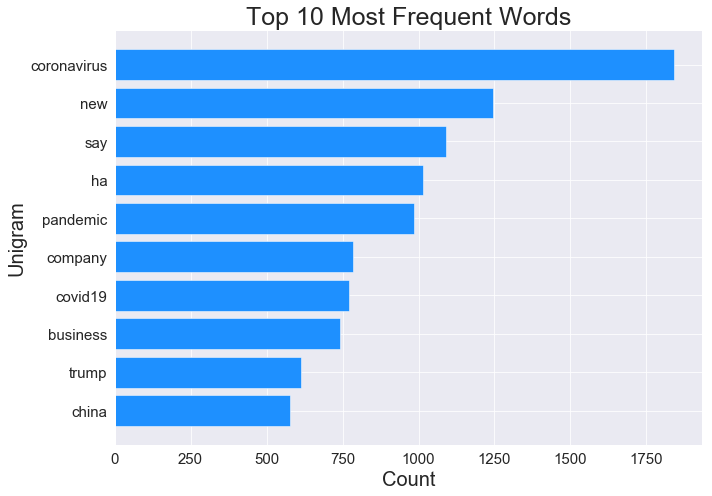

In [23]:
top_10_words_count = list(word_counts_dict.values())[:10]

plot_horizontal_bar_chart(top_10_words, top_10_words_count, "Top 10 Most Frequent Words",
              "Count", "Unigram")

plt.savefig('imgs/top_10_unigrams.png')

Given current events, it is unsurprising to see that the top 10 most frequest words during the 1 month period include: 'coronavirus', 'pandemic', 'covid19', 'trump', and 'china'.

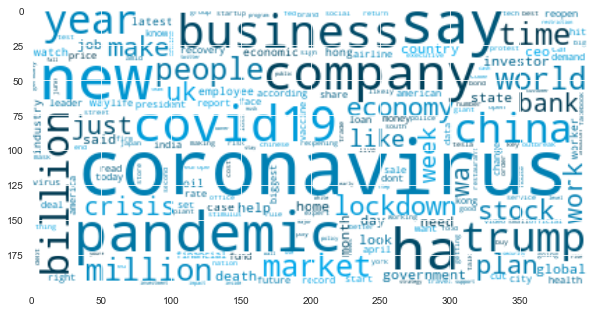

In [24]:
create_wordcloud(word_counts_dict)
plt.savefig('imgs/unigrams_wordclound.png')

### What about n-grams? 

Extracting n-grams (n > 1) from a corpus can help provide contextual information as opposed to viewing single words (unigrams).

Will first extract bigrams to see if more information can be extracted from the tweets.

In [25]:
vect = CountVectorizer(stop_words='english', ngram_range=(2,2))
X_train_vect = vect.fit_transform(X_train).todense()

In [26]:
word_counts_dict = create_word_counts_dict(vect, X_train_vect)

In [27]:
top_10_bigrams = list(word_counts_dict.keys())[:10]
top_10_least_freq_bigrams = list(word_counts_dict.keys())[-10:]

print("Length of bag of words is: ", len(word_counts_dict))
print("\nThe top 10 most bi-grams are: ", top_10_bigrams)
print("\nThe top 10 least bi-grams are: ", top_10_least_freq_bigrams)

Length of bag of words is:  105954

The top 10 most bi-grams are:  ['coronavirus pandemic', 'hong kong', 'new york', 'elon musk', 'wall street', 'small business', 'white house', 'coronavirus outbreak', 'central bank', 'coronavirus crisis']

The top 10 least bi-grams are:  ['zuckerbergs failure', 'zuckerbergs lieutenant', 'zukerman cofounder', 'zuma wa', 'zume laid', 'zume selling', 'zurich insurance', 'zurich london', 'zx venture', 'zynga buy']


This is amazing, there's so much more information that can be inferred using bi-grams! 

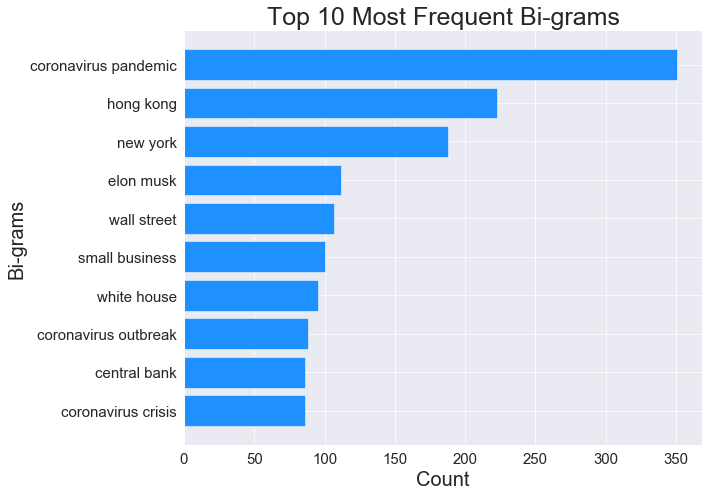

In [28]:
top_10_bigrams_count = list(word_counts_dict.values())[:10]

plot_horizontal_bar_chart(top_10_bigrams, top_10_bigrams_count, "Top 10 Most Frequent Bi-grams",
              "Count", "Bi-grams")
plt.savefig('imgs/top_10_bigrams.png')

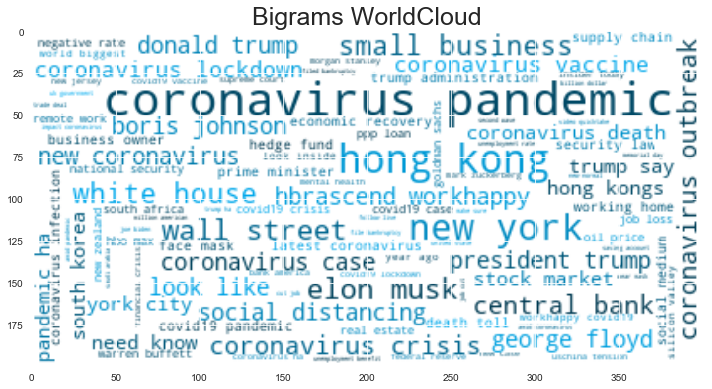

In [29]:
create_wordcloud(word_counts_dict)
plt.title('Bigrams WorldCloud', fontsize=25)
plt.tight_layout()
plt.savefig('imgs/bigrams_wordcloud.png')

Can even more information be extracted through tri-grams?

In [30]:
vect = CountVectorizer(stop_words='english', ngram_range=(3,3))
X_train_vect = vect.fit_transform(X_train).todense()

In [31]:
word_counts_dict = create_word_counts_dict(vect, X_train_vect)

In [32]:
top_10_trigrams = list(word_counts_dict.keys())[:10]
top_10_least_freq_trigrams = list(word_counts_dict.keys())[-10:]

print("Length of bag of words is: ", len(word_counts_dict))
print("\nThe top 10 most bi-grams are: ", top_10_trigrams)
print("\nThe top 10 least bi-grams are: ", top_10_least_freq_trigrams)

Length of bag of words is:  116616

The top 10 most bi-grams are:  ['new york city', 'hbrascend workhappy covid19', 'new coronavirus case', 'national security law', 'death george floyd', 'coronavirus pandemic ha', 'world health organization', 'coronavirus death toll', 'economy stay coronavirusfree', 'george floyd protest']

The top 10 least bi-grams are:  ['zuckerbergs decision peter', 'zuckerbergs failure flag', 'zuckerbergs lieutenant facebook', 'zukerman cofounder soulcycle', 'zuma wa forced', 'zume laid combined', 'zume selling face', 'zurich insurance pay', 'zx venture helping', 'zynga buy turkish']


Interestingly, having tri-grams creates a bit more confusion in regards to what sort of business topics were being tweeted during the one-month period.

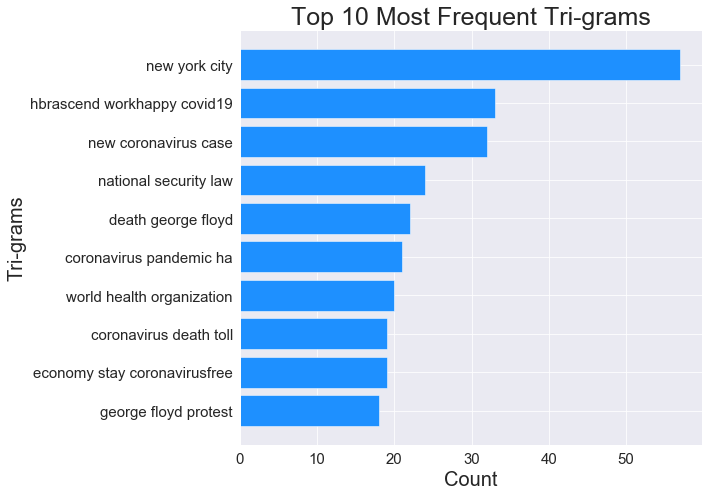

In [33]:
top_10_trigrams_count = list(word_counts_dict.values())[:10]

plot_horizontal_bar_chart(top_10_trigrams, top_10_trigrams_count, "Top 10 Most Frequent Tri-grams",
              "Count", "Tri-grams")
plt.savefig('imgs/top_10_trigrams.png')

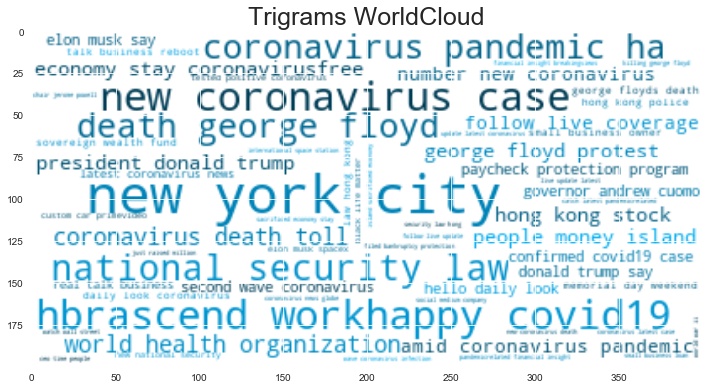

In [34]:
create_wordcloud(word_counts_dict)
plt.title('Trigrams WorldCloud', fontsize=25)
plt.tight_layout()
plt.savefig('imgs/trigrams_wordcloud.png')

## Create Base Model using Logistic Regression

This base model removes stopwords, uses the CountVectorizer, and SMOTE to account for class imbalance.

### CountVectorizer

The CountVectorizer provides a way to tokenize and vectorize a collection of text documents, so that the words extracted from the documents can be consumed by the model.

The CountVectorizer returns a vocabulary and the count of the number of times a word appears in a document.

### SMOTE

SMOTE (Synthetic Minority Oversampling Technique) is an oversampling method that is used to handle class imbalance. 

This technique works by creating examples of the minority class by selecting a random instance of the minority class and finding it's k-nearest minority class neighbors.

The synthetic instance is created by choosing one of the k-nearest neighbors at random and connecting a line between the examples, creating a new sample point along that line.

Some downsides to this method of oversampling is overfitting and the fact that the majority class is not considered when creating the synthetic samples.

In [35]:
vect = CountVectorizer(stop_words='english').fit(X_train)
X_train_vect = vect.transform(X_train)

In [36]:
# use SMOTE to oversample and account for class imbalance
sm = SMOTE(random_state=2)
X_train_res, y_train_res = sm.fit_sample(X_train_vect, y_train)

Double check that the SMOTE function worked, both classes should be balanced.

In [37]:
from collections import Counter
print('From before oversampling: ', Counter(y_train))
print('From after oversampling: ', Counter(y_train_res))

From before oversampling:  Counter({1: 14381, 0: 318})
From after oversampling:  Counter({1: 14381, 0: 14381})


In [38]:
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10]}
grid = GridSearchCV(LogisticRegression(), param_grid=param_grid, cv=5)
grid.fit(X_train_res, y_train_res)

/Users/seanleong/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/seanleong/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear

GridSearchCV(cv=5, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [39]:
print("Best cross validation score: {}".format(grid.best_score_))
print("Best parameters: ", grid.best_params_)

Best cross validation score: 0.962381548769258
Best parameters:  {'C': 10}


The 'C' hyperparameter in the Logistic Regression function in SkLearn is an inverse regularization parameter. It is a penalty term that is meant to control against overfitting. 

According to SkLearn, C = 1/λ. A higher C, means a lower value for λ, therefore less regularization.  

In [40]:
X_test_vect = vect.transform(X_test)
print('Test score: {:.2f}'.format(grid.score(X_test_vect, y_test)))

Test score: 0.93


In [41]:
logistic1 = LogisticRegression(C=10)
logistic1.fit(X_train_res, y_train_res)

/Users/seanleong/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [42]:
y_pred = logistic1.predict(X_test_vect)

In [43]:
y_hat = logistic1.predict_proba(X_test_vect)

In [44]:
print_acc_prec_recall(y_test, y_pred)

Accuracy score:  0.9326530612244898
Precision:  0.9833261152013859
Recall:  0.9472256987901544


### Primary Metric:

Precision will be the primary metric that will be used to measure and assess how well the different iterations of the model do. Precision measures the number of true positives that were predictived as positive by the model.

It is important to minimize the number of False Positives (FPs) - Tweets that are incorrectly classified as 'Business' topics, but actually are not. The higher number of FPs is more detrimental compared to the number of False Negatives (FNs) in this context. Any content that appears and is not Business related would result in users losing faith in the ability of the app to provide him/her with the information he/she is looking for, potentially resulting in user churn. 

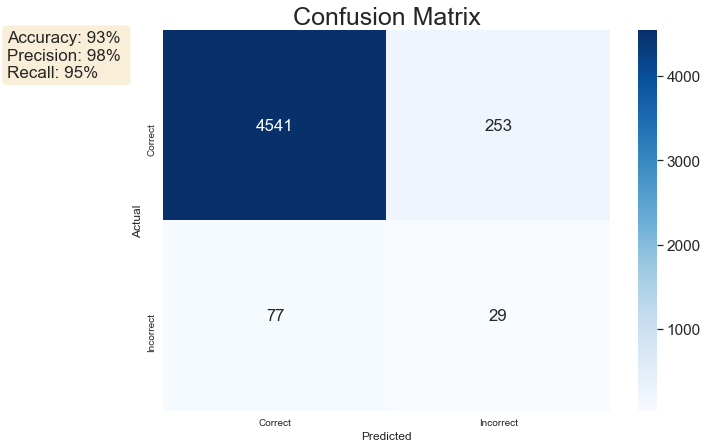

In [45]:
fig, ax = plt.subplots(figsize=(10, 7))
get_conf_matrix(y_test, y_pred, ax)
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
plt.text(-.35, 1, 'Accuracy: 93% \nPrecision: 98% \nRecall: 95%', fontsize=17, verticalalignment='top', horizontalalignment='left',transform=ax.transAxes, bbox=props);

The AUC for this model 66%, which is not so great. AUC provides an overall measure of performance of the model across all multiple classification thresholds.

Although precision is the primary metric of concern, will look to see if it's possible to increase the AUC as well.

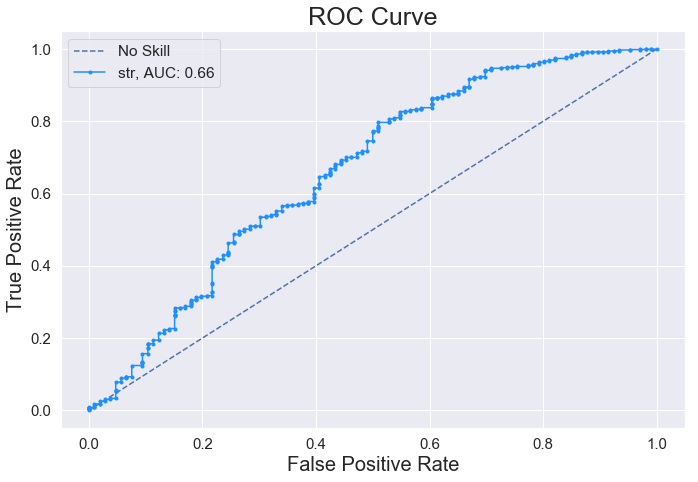

In [46]:
plot_roc_curve(y_hat, y_test, 'Logistic')

The below Precision-Recall curve shows that the model is doing an ok job above the no skill line for most thresholds. However, the model is unsure about predicting certain datapoints, showing very high precision and very low recall. 

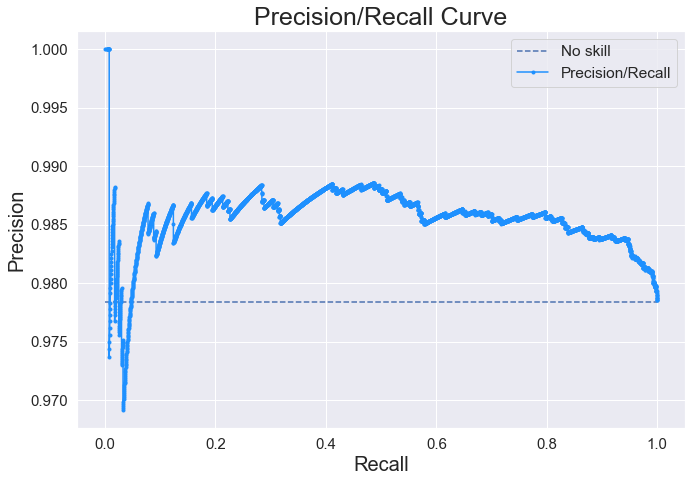

In [47]:
plot_prec_recall(y_hat, y_test)

## Create another Logistic Regression model using, class_weight = 'balanced', CountVectorizer and compare results

Another method that can be used to address class imbalance is using SkLearn's class_weight parameter. 

By setting the class_weight = 'balanced', a higher weight will be given to the minority class and the model will be penalized for misclassifying the minority class.

In [48]:
vect = CountVectorizer(stop_words='english').fit(X_train)
X_train_vect = vect.transform(X_train)

In [49]:
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10]}
grid = GridSearchCV(LogisticRegression(class_weight='balanced'), param_grid=param_grid, cv=5)
grid.fit(X_train_vect, y_train)

/Users/seanleong/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/seanleong/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear

GridSearchCV(cv=5, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight='balanced',
                                          dual=False, fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [50]:
print("Best cross validation score: {}".format(grid.best_score_))
print("Best parameters: ", grid.best_params_)

Best cross validation score: 0.9682971439681692
Best parameters:  {'C': 10}


In [51]:
logistic2 = LogisticRegression(C=10, class_weight='balanced')
logistic2.fit(X_train_vect, y_train)

/Users/seanleong/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=10, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [52]:
X_test_vect = vect.transform(X_test)
y_pred = logistic2.predict(X_test_vect)

In [53]:
y_hat = logistic2.predict_proba(X_test_vect)

Accuracy and recall score each improved by 3%, while precision remains consistent at 98% compared to the first Logistic Regression model.

In [54]:
print_acc_prec_recall(y_test, y_pred)

Accuracy score:  0.9630612244897959
Precision:  0.9820271682340648
Recall:  0.9801835627868168


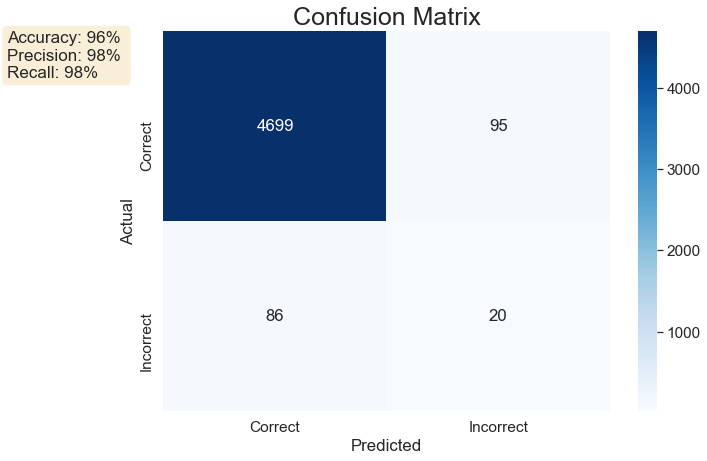

In [55]:
fig, ax = plt.subplots(figsize=(10, 7))
get_conf_matrix(y_test, y_pred, ax)

props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
plt.text(-.35, 1, 'Accuracy: 96% \nPrecision: 98% \nRecall: 98%', fontsize=17, verticalalignment='top', horizontalalignment='left',transform=ax.transAxes, bbox=props);
plt.savefig('imgs/base_model_cm.png', bbox_inches='tight')

AUC for the ROC curve improved by 6% compared to the prior model.

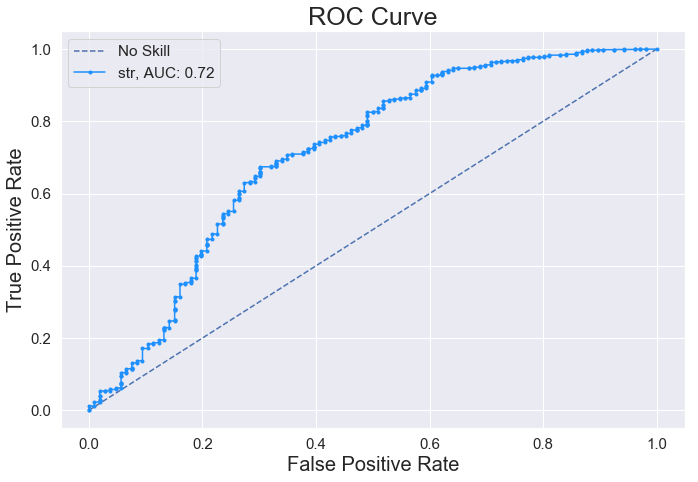

In [56]:
plot_roc_curve(y_hat, y_test, 'Logistic')
plt.savefig('imgs/base_model_roc.png')

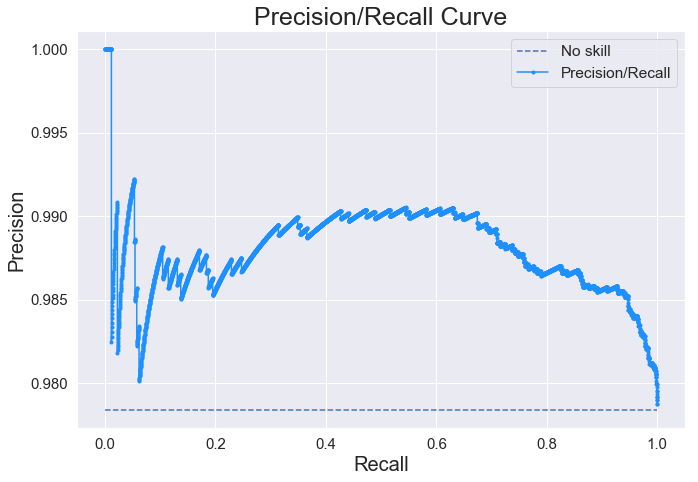

In [57]:
plot_prec_recall(y_hat, y_test)
plt.savefig('imgs/base_model_prec_recall.png')

## Using same hyperparameters with TFIDF

### Term Frequency- Inverse Document Frequency (TFIDF)

Instead of using the CountVectorizer, which only shows the count of a word appears in the document, the TFIDF vectorizer will be used.

TFIDF calculates the weight to each word in the vocabulary and shows the importance of the word in a document and corpus.

In [58]:
vect = TfidfVectorizer(stop_words='english').fit(X_train)
X_train_vect = vect.transform(X_train)

In [59]:
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10]}
grid = GridSearchCV(LogisticRegression(class_weight='balanced'), param_grid=param_grid, cv=5)
grid.fit(X_train_vect, y_train)

/Users/seanleong/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/seanleong/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear

GridSearchCV(cv=5, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight='balanced',
                                          dual=False, fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [60]:
print("Best cross validation score: {}".format(grid.best_score_))
print("Best parameters: ", grid.best_params_)

Best cross validation score: 0.971290526418121
Best parameters:  {'C': 10}


In [61]:
logistic3 = LogisticRegression(C=10, class_weight='balanced')
logistic3.fit(X_train_vect, y_train)

/Users/seanleong/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=10, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [62]:
X_test_vect = vect.transform(X_test)
y_pred = logistic3.predict(X_test_vect)

In [63]:
y_hat = logistic3.predict_proba(X_test_vect)

This model shows similar results to the second Logistic Regression model with 0.06% increase in precision score.

In [64]:
print_acc_prec_recall(y_test, y_pred)

Accuracy score:  0.9636734693877551
Precision:  0.9826432455039732
Recall:  0.9801835627868168


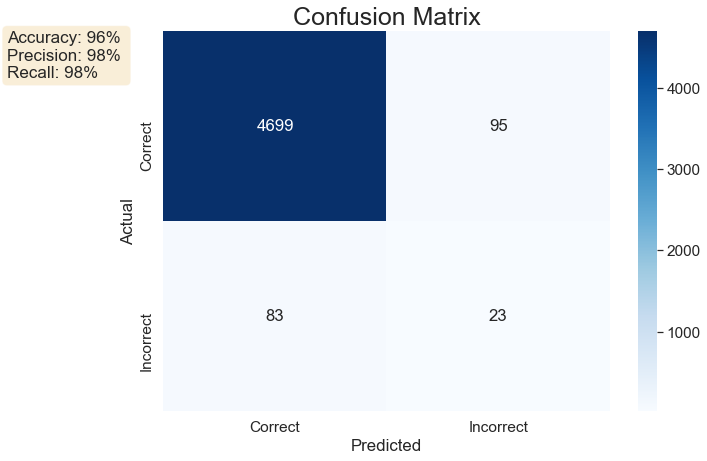

In [65]:
fig, ax = plt.subplots(figsize=(10, 7))
get_conf_matrix(y_test, y_pred, ax)
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
plt.text(-.35, 1, 'Accuracy: 96% \nPrecision: 98% \nRecall: 98%', fontsize=17, verticalalignment='top', horizontalalignment='left',transform=ax.transAxes, bbox=props);

The AUC is a noticeable improvement from the first model's AUC at 66%.

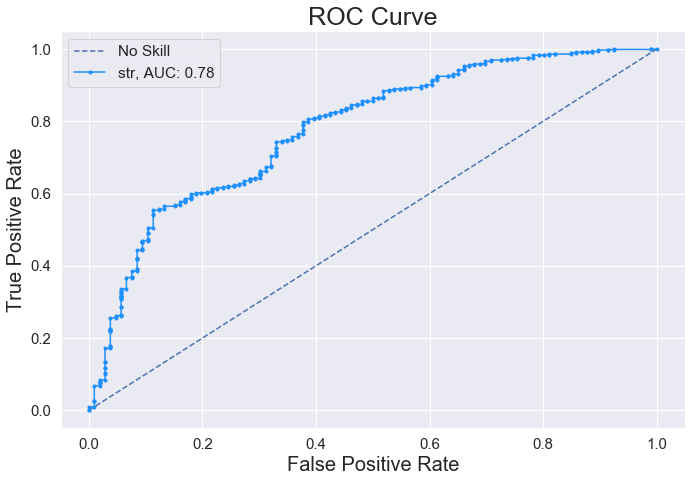

In [66]:
plot_roc_curve(y_hat, y_test, 'Logistic')

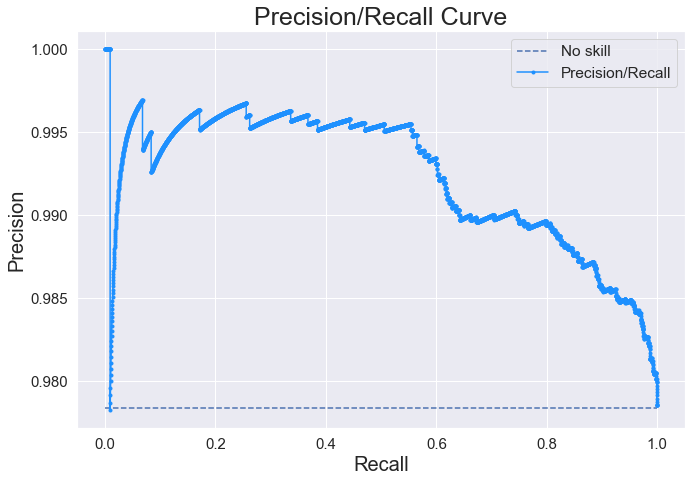

In [67]:
plot_prec_recall(y_hat, y_test)

The threshold for the classifier is tweaked to see if the precision score can be improved.

In [68]:
# tweak thresholds to try and find optimal precision score for model
thresholds = np.arange(0.3, 1, 0.1)

thresholds, precision_scores, recall_scores = tweak_tresholds(thresholds, X_test_vect, y_test, logistic3)

Threshold of 0.3
Accuracy score:  0.9716326530612245
Precision:  0.9811866859623734
Recall:  0.9899874843554443


Threshold of 0.4
Accuracy score:  0.9677551020408163
Precision:  0.9821131447587355
Recall:  0.9849812265331664


Threshold of 0.5
Accuracy score:  0.9636734693877551
Precision:  0.9826432455039732
Recall:  0.9801835627868168


Threshold of 0.6000000000000001
Accuracy score:  0.9581632653061225
Precision:  0.9831543482838492
Recall:  0.9739257405089695


Threshold of 0.7000000000000002
Accuracy score:  0.9481632653061225
Precision:  0.9842150170648464
Recall:  0.9624530663329162


Threshold of 0.8000000000000003
Accuracy score:  0.9293877551020409
Precision:  0.984954208460532
Recall:  0.9422194409678765


Threshold of 0.9000000000000001
Accuracy score:  0.8806122448979592
Precision:  0.9863646868500116
Recall:  0.8902795160617438




As the values of the threshold increases, there is a tradeoff between precision and recall. Based on the graph below, after the threshold value of 0.6, there is a significant decrease in the recall score with minimal increase in the precision score.

As a result, the ideal threshold for the third Logistic Regression model is 0.6.

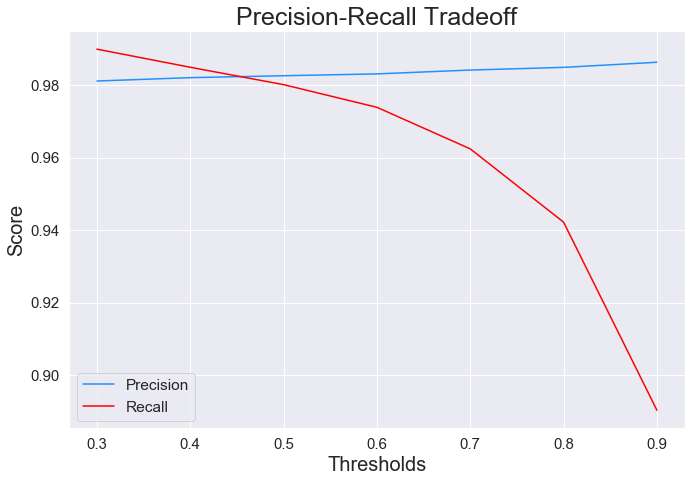

In [69]:
# plot precision and recall metrics against thresholds to visualize tradeoff
# and selecting optimal threshold
fig, ax = plt.subplots(figsize=(10, 7))

plt.plot(thresholds, precision_scores, color='dodgerblue', label='Precision')
plt.plot(thresholds, recall_scores, color='red', label='Recall')

plt.title('Precision-Recall Tradeoff', fontsize=25)
ax.set_xlabel('Thresholds', fontsize=20)
ax.set_ylabel('Score', fontsize=20)

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend()
plt.tight_layout()

In [70]:
y_pred = (logistic3.predict_proba(X_test_vect)[:, 1] > 0.6).astype(int)

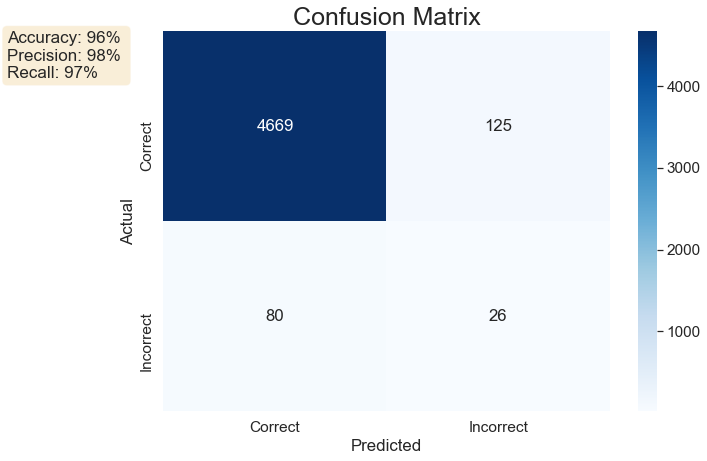

In [71]:
fig, ax = plt.subplots(figsize=(10, 7))
get_conf_matrix(y_test, y_pred, ax)
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
plt.text(-.35, 1, 'Accuracy: 96% \nPrecision: 98% \nRecall: 97%', fontsize=17, verticalalignment='top', horizontalalignment='left',transform=ax.transAxes, bbox=props);

## Logistic Regression with Bi-grams

The models created up until this point contain contain unigrams. Will the model perform better with bi-grams instead? 

In [72]:
vect = TfidfVectorizer(stop_words='english', ngram_range=(2,2)).fit(X_train)
X_train_vect = vect.transform(X_train)

In [73]:
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10]}
grid = GridSearchCV(LogisticRegression(class_weight='balanced'), param_grid=param_grid, cv=5)
grid.fit(X_train_vect, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight='balanced',
                                          dual=False, fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [74]:
print("Best cross validation score: {}".format(grid.best_score_))
print("Best parameters: ", grid.best_params_)

Best cross validation score: 0.9790462071184377
Best parameters:  {'C': 10}


In [75]:
logistic4 = LogisticRegression(C=10, class_weight='balanced')
logistic4.fit(X_train_vect, y_train)

LogisticRegression(C=10, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [76]:
X_test_vect = vect.transform(X_test)
y_pred = logistic4.predict(X_test_vect)

In [77]:
y_hat = logistic4.predict_proba(X_test_vect)

In [78]:
print_acc_prec_recall(y_test, y_pred)

Accuracy score:  0.9722448979591837
Precision:  0.9815963606286187
Recall:  0.9901960784313726


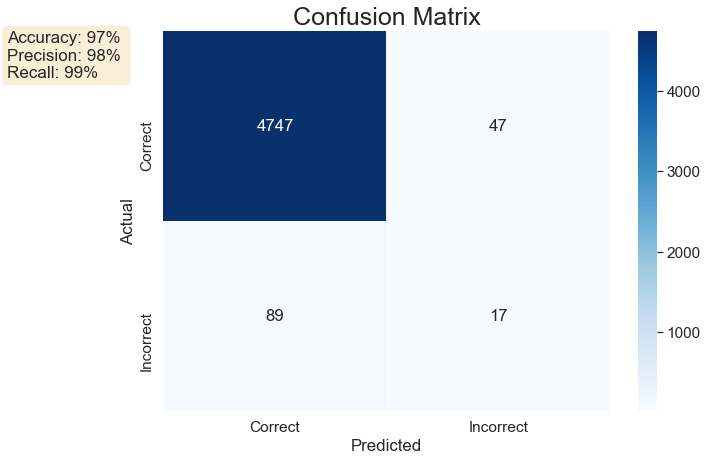

In [79]:
fig, ax = plt.subplots(figsize=(10, 7))
get_conf_matrix(y_test, y_pred, ax)

props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
plt.text(-.35, 1, 'Accuracy: 97% \nPrecision: 98% \nRecall: 99%', fontsize=17, verticalalignment='top', horizontalalignment='left',transform=ax.transAxes, bbox=props)

plt.savefig('imgs/final_model_cm.png', bbox_inches='tight');

AUC showed marginal improvement from 78% to 79%.

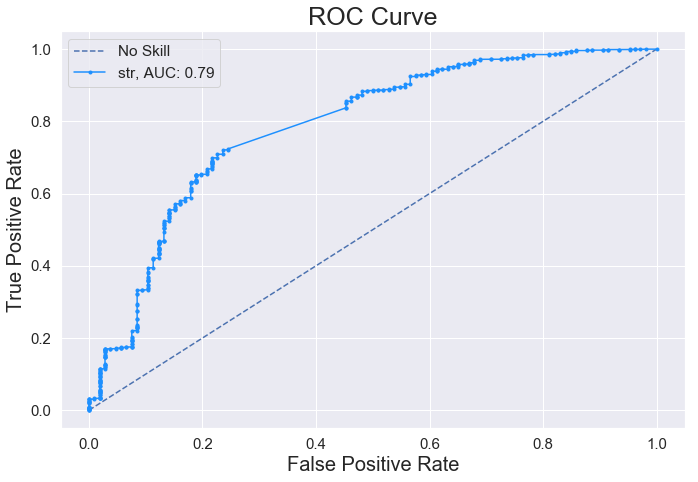

In [80]:
plot_roc_curve(y_hat, y_test, 'Logistic')
plt.savefig('imgs/final_model_roc.png')

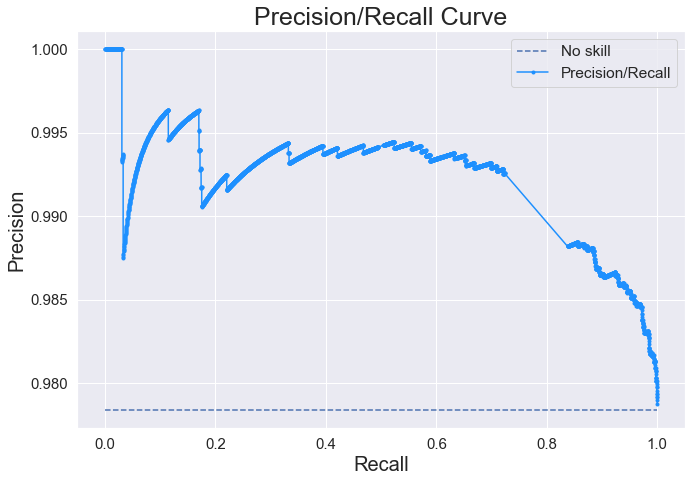

In [81]:
plot_prec_recall(y_hat, y_test)
plt.savefig('imgs/final_model_prec_recall.png')

In [82]:
# tweak thresholds to try and find optimal precision score for model
thresholds = np.arange(0.3, 1, 0.1)

thresholds, precision_scores, recall_scores = tweak_tresholds(thresholds, X_test_vect, y_test, logistic4)

Threshold of 0.3
Accuracy score:  0.9777551020408163
Precision:  0.9813026505033902
Recall:  0.9962453066332916


Threshold of 0.4
Accuracy score:  0.9751020408163266
Precision:  0.9814509480626545
Recall:  0.9933249895702962


Threshold of 0.5
Accuracy score:  0.9722448979591837
Precision:  0.9815963606286187
Recall:  0.9901960784313726


Threshold of 0.6000000000000001
Accuracy score:  0.970204081632653
Precision:  0.9817578772802653
Recall:  0.9879015435961619


Threshold of 0.7000000000000002
Accuracy score:  0.9677551020408163
Precision:  0.9827155351936693
Recall:  0.9843554443053817


Threshold of 0.8000000000000003
Accuracy score:  0.96
Precision:  0.9831862126944094
Recall:  0.9758030871923238


Threshold of 0.9000000000000001
Accuracy score:  0.94
Precision:  0.9851228978007762
Recall:  0.9530663329161452




Recall declines significantly at threshold value of 0.75. It seems like the best threshold value for this version of the model is 0.8 since improvement in the precision score is marginal from that point on.

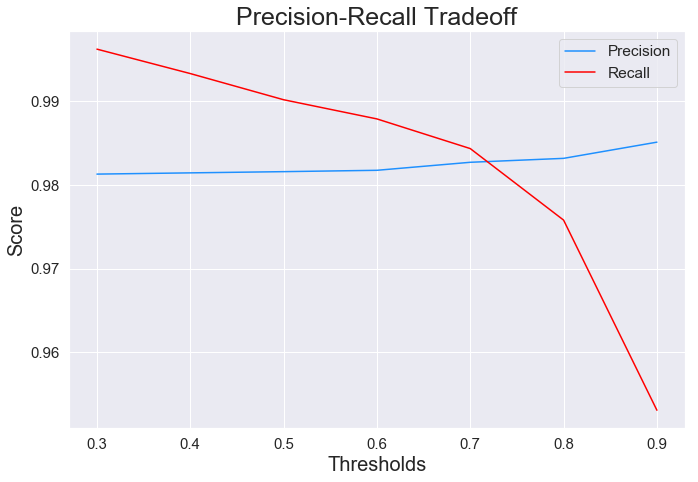

In [83]:
# plot precision and recall metrics against thresholds to visualize tradeoff
# and selecting optimal threshold
fig, ax = plt.subplots(figsize=(10, 7))

plt.plot(thresholds, precision_scores, color='dodgerblue', label='Precision')
plt.plot(thresholds, recall_scores, color='red', label='Recall')

plt.title('Precision-Recall Tradeoff', fontsize=25)
ax.set_xlabel('Thresholds', fontsize=20)
ax.set_ylabel('Score', fontsize=20)

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend()
plt.tight_layout()
plt.savefig('imgs/final_model_prec_recall_tradeoff.png')

In [84]:
y_pred_adj = (logistic4.predict_proba(X_test_vect)[:, 1] > 0.8).astype(int)

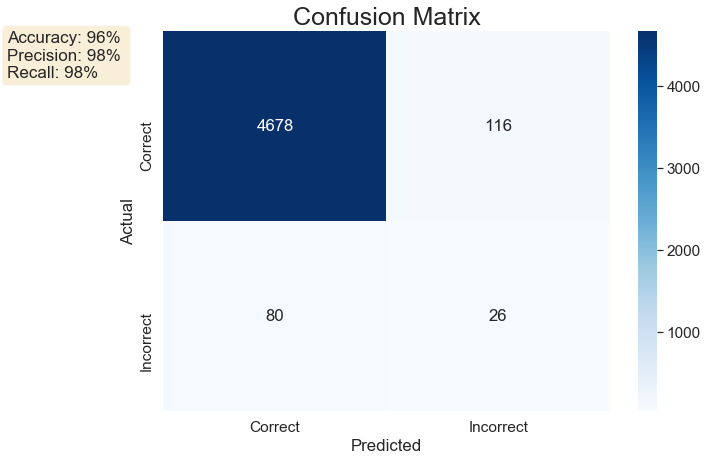

In [85]:
fig, ax = plt.subplots(figsize=(10, 7))
get_conf_matrix(y_test, y_pred_adj, ax)
plt.text(-.35, 1, 'Accuracy: 96% \nPrecision: 98% \nRecall: 98%', fontsize=17, verticalalignment='top', horizontalalignment='left',transform=ax.transAxes, bbox=props);

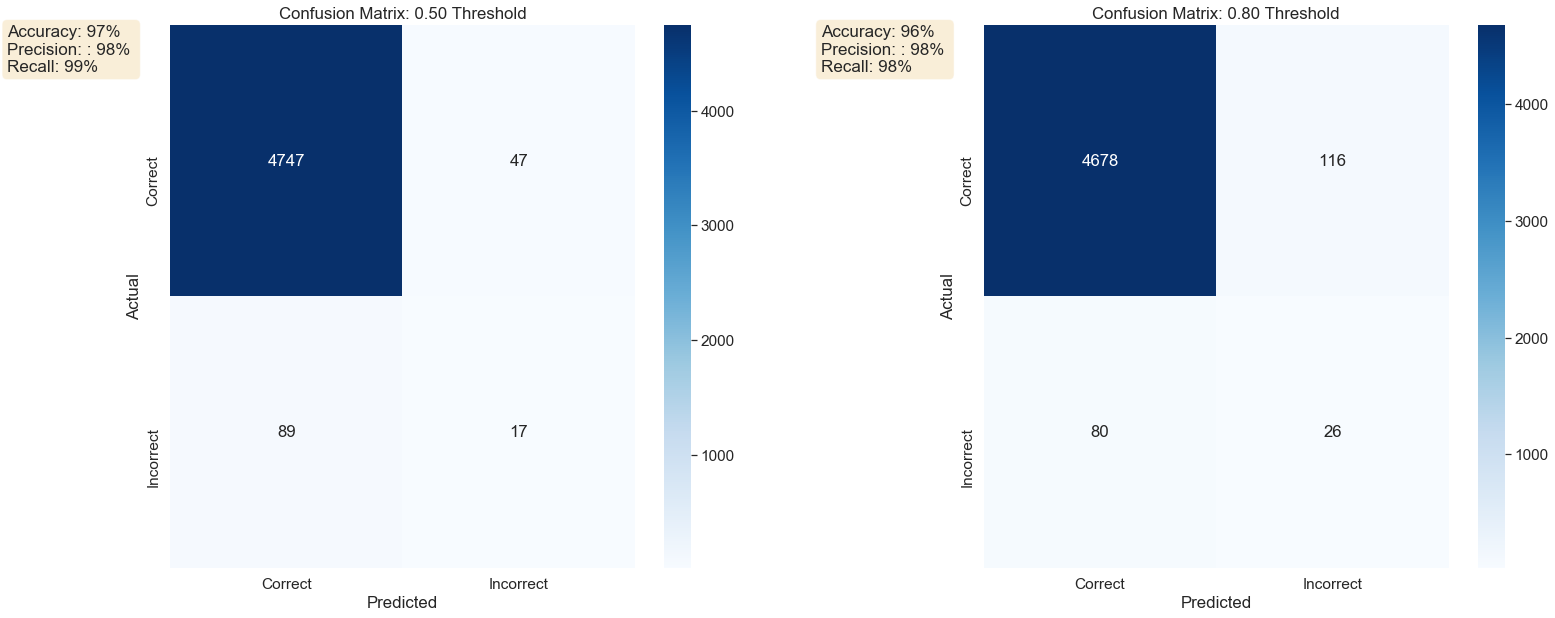

In [86]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

fig, axs = plt.subplots(1,2, figsize=(25,10))
fig.subplots_adjust(wspace=0.4)
lst = [y_pred, y_pred_adj]
thresholds = [0.5, 0.8]
accuracy = [0.97, 0.96]
precision = [0.98, 0.98]
recall = [0.99, 0.98]

for i, ax in enumerate(axs.flatten()):
    get_conf_matrix(y_test, lst[i], ax)
    ax.set_title('Confusion Matrix: {:.2f} Threshold'.format(thresholds[i], fontsize=25))
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    ax.text(-.35, 1, 'Accuracy: {:.0%} \nPrecision: : {:.0%} \nRecall: {:.0%}'.format(accuracy[i],precision[i], recall[i]), 
                                                        fontsize=17, verticalalignment='top', horizontalalignment='left',transform=ax.transAxes, bbox=props);

plt.savefig('imgs/final_model_cm_comparison.png')

## Comparing Different Models

Is it possible to further improve this model using something other than a Logistic Regression? 

In [87]:
vect = TfidfVectorizer(stop_words='english', ngram_range=(2,2)).fit(X_train)
X_train_vect = vect.transform(X_train)

In [88]:
X_test_vect = vect.transform(X_test)

A pipeline is created to vectorize and construct the simple Logistic Regression that was used before.

In [89]:
pipeline = Pipeline([('vect', TfidfVectorizer(stop_words='english', ngram_range=(2,2))),
                    ('classifier', LogisticRegression(class_weight='balanced'))])

In [90]:
param_grid = [{'classifier': [LogisticRegression()],
              'classifier__C': [0.001, 0.01, 0.1, 1, 10]},
             {'classifier': [RandomForestClassifier()],
             'classifier__n_estimators': np.arange(10, 101, 10),
             'classifier__max_depth': [5, 10, 15, 20],
             'classifier__class_weight': [None, 'balanced']}]

In [91]:
grid = GridSearchCV(pipeline, param_grid=param_grid, cv=5, verbose=True, n_jobs=-1)
grid.fit(X_train, y_train)

Fitting 5 folds for each of 85 candidates, totalling 425 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:   24.4s
[Parallel(n_jobs=-1)]: Done 425 out of 425 | elapsed:   58.4s finished


GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('vect',
                                        TfidfVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.float64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(2, 2),
                                                        no

According to the grid search, the model that performed that best was a Random Forest Classifier with a balanced class weight, max depth of 20, and 80 trees.

In [92]:
print(grid.best_score_)
print(grid.best_params_)

0.9793184085474952
{'classifier': RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=15, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=60,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False), 'classifier__class_weight': 'balanced', 'classifier__max_depth': 15, 'classifier__n_estimators': 60}


In [93]:
grid.score(X_test, y_test)

0.9779591836734693

However, based on the ROC curves shown below, the Random Forest Classifier has a significantly lower AUC than the Logistic Regression model. 

In the end, the Logistic Regression model was the best choice given the higher AUC score and its easy implementation, interpretability, and quick training time.

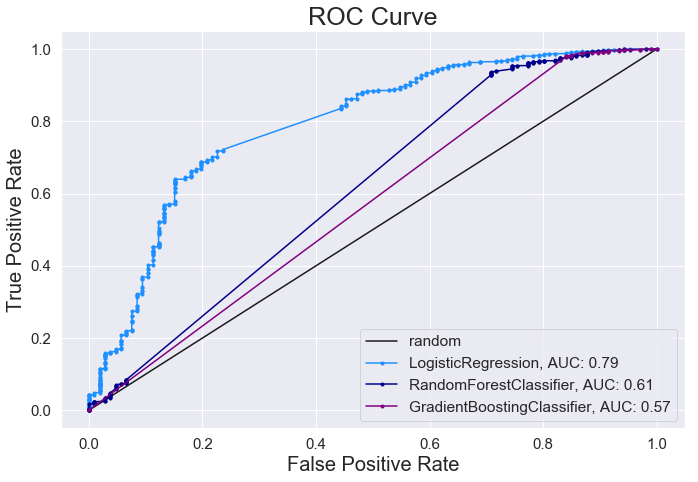

In [94]:
models = [LogisticRegression(class_weight='balanced'), RandomForestClassifier(class_weight='balanced', max_depth=20, n_estimators=80), GradientBoostingClassifier()]
colors = ['dodgerblue', 'darkblue', 'purple']

plot_multiple_rocs(models, colors, X_train_vect, y_train, X_test_vect, y_test)
plt.savefig('imgs/multiple_models_roc.png')